# Assignment - Sentiment Analysis of Movie Reviews

![](https://i.imgur.com/6Wfmf2S.png)

> **Problem Statement**: Apply the TF-IDF technique to train ML models for sentiment analysis using data from the "[Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)" Kaggle competition.


Outline:

1. Download and Explore Dataset
2. Implement the TF-IDF Technique
3. Train baseline model & submit to Kaggle
4. Train & finetune different ML models
3. Document & submit your notebook


Dataset: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews


## Download and Explore the Data

Outline:

1. Download Dataset from Kaggle
2. Explore and visualize data

### Download Dataset from Kaggle

- Read the "Description", "Evaluation" and "Data" sections on the Kaggle competition page carefully
- Make sure to download the `kaggle.json` file from your [Kaggle account](https://kaggle.com/me/account) and upload it on Colab

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "."

In [2]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews
!unzip sentiment-analysis-on-movie-reviews.zip

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 114MB/s]
Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


### Explore and Visualize Data

* Load the train, test, and submission files using Pandas
* Explore rows, columns, sample values etc.
* Visualize distribution of target columns

In [3]:
import pandas as pd

In [6]:
raw_df = pd.read_csv('train.tsv.zip', sep='\t')
test_df = pd.read_csv('test.tsv.zip', sep='\t')


In [7]:
submission_df = pd.read_csv('sampleSubmission.csv')

In [8]:
raw_df.shape, test_df.shape, submission_df.shape

((156060, 4), (66292, 3), (66292, 2))

In [9]:
raw_df.isna().any()

PhraseId      False
SentenceId    False
Phrase        False
Sentiment     False
dtype: bool

In [15]:
test_df.isna().any()

PhraseId      False
SentenceId    False
Phrase        False
dtype: bool

In [11]:
# Iterate over the rows and print the index of rows with NaN in 'Phrase' column
for index, attr in test_df.Phrase.items():
    if pd.isna(attr):
        print(f"NaN value found at row index: {index}")

NaN value found at row index: 15519


In [14]:
test_df.iloc[15519]

PhraseId            171580
SentenceId            9213
Phrase        None of this
Name: 15519, dtype: object

In [13]:
test_df.at[15519, 'Phrase'] = 'None of this'


Summarize your insights and learnings from the dataset below:

* The train.tsv file contains phrases and their corresponding sentiment labels. It also includes a SentenceId to track which phrases belong to the same sentence.
* test.tsv contains just phrases. we must assign a sentiment label to each phrase.
* The sentiment labels are -> 0 - negative, 1 - somewhat negative, 2 - neutral, 3 - somewhat positive, 4 - positive
* found a NAN attribute in the test df and removed it, correspondingly in the submission column
* Apparently removing it leads to problems in submissions so updated the missing field with a new value 'None of this'

## Implement TF-IDF Technique

![](https://i.imgur.com/5VbUPup.png)

Outline:

1. Learn the vocabulary using `TfidfVectorizer`
3. Transform training and test data

#### Learn Vocabulary using `TfidfVectorizer `

* Create custom tokenizer with stemming
* Create a list of stop words
* Configure and create `TfidfVectorizer `
* Learn vocubulary from training set
* View sample entries from vocabulary

In [16]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [18]:
stemmer = SnowballStemmer('english')

Create custom tokenizer with stemming


---


created and its working

In [19]:
def tokenize(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.isalnum()]

    return stemmed_tokens

In [20]:
tokenize('This is a test sentence.')

['this', 'is', 'a', 'test', 'sentenc']

Create a list of stop words


---


created

In [23]:
stopwords = stopwords.words('english')

In [24]:
", ".join(stopwords)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

**Context Sensitivity:** In some cases, stop words can contribute to the sentiment of a sentence. For instance, "not good" has a different sentiment than "good". Removing "not" would lose this important context. Hence, im removing all the negative stop words

In [25]:
filtered_stopwords = stopwords[:116]

**Domain-Specific Stop Words:** Consider creating a custom stop word list tailored to movie reviews. For example, words like "movie", "film", "actor" might be common but not useful for sentiment analysis.

In [26]:
filtered_stopwords.append('movie')

In [27]:
filtered_stopwords.append('film')
filtered_stopwords.append('actor')

In [28]:
type(filtered_stopwords)

list

**Why Remove Stop Words?**
- **Noise Reduction**: Stop words (common words like "the", "is", "in", etc.) often don't carry significant meaning and can act as noise, potentially confusing the model.
- **Dimensionality Reduction**: By removing stop words, you reduce the number of features, which can make the model training more efficient and improve performance.

Configure and create TfidfVectorizer

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
vectorizer = TfidfVectorizer(tokenizer=tokenize,
                             stop_words=filtered_stopwords,
                             ngram_range=(1,2),
                             max_features=2000)

In [31]:
q1 = raw_df.Phrase[0]
q1

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [32]:
", ".join(tokenize(q1))

'a, seri, of, escapad, demonstr, the, adag, that, what, is, good, for, the, goos, is, also, good, for, the, gander, some, of, which, occasion, amus, but, none, of, which, amount, to, much, of, a, stori'

In [33]:
%%time
# Learn the vocabulary from the training data
vectorizer.fit(raw_df.Phrase)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'movi', 'onc', 'ourselv', 'themselv', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 35.5 s, sys: 209 ms, total: 35.7 s
Wall time: 37.4 s


TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f7d0543add0>)

Learn vocubulary from training set and View sample entries from vocabulary

In [34]:
type(vectorizer.vocabulary_)

dict

In [35]:
vectorizer.get_feature_names_out()[:200]

array(['10', '10 minut', '15', '2', '20', '2002', '9', '90', '90 minut',
       'abandon', 'abil', 'abl', 'abov', 'absolut', 'absorb', 'abstract',
       'absurd', 'abus', 'accent', 'accept', 'access', 'accomplish',
       'accur', 'ach', 'achiev', 'across', 'act', 'action', 'action movi',
       'action sequenc', 'actress', 'actual', 'ad', 'adam',
       'adam sandler', 'adapt', 'add', 'addit', 'adequ', 'admir', 'admit',
       'adolesc', 'adult', 'adventur', 'affair', 'affect', 'afraid',
       'age', 'ago', 'ahead', 'aim', 'aimless', 'air', 'alien', 'aliv',
       'allen', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also',
       'altern', 'although', 'alway', 'amateurish', 'amaz', 'ambigu',
       'ambit', 'ambiti', 'america', 'american', 'among', 'amount',
       'amus', 'analyz', 'angel', 'angst', 'ani', 'anim', 'ann', 'annoy',
       'anoth', 'answer', 'anyon', 'anyth', 'apart', 'appar', 'appeal',
       'appear', 'appli', 'appreci', 'approach', 'appropri', 'area',
       'a

### Transform Training & Test Data

* Transform phrases from training set
* Transform phrases from test set
* Look at some example values

Transform phrases from training set

In [36]:
%%time
inputs = vectorizer.transform(raw_df.Phrase)

In [37]:
inputs

<156060x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 464139 stored elements in Compressed Sparse Row format>

In [38]:
inputs.toarray()[0][:100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.27620188, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.33022325, 0.29314

Transform phrases from test set


In [39]:
%%time
test_inputs = vectorizer.transform(test_df.Phrase)

In [40]:
test_inputs

<66292x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 178144 stored elements in Compressed Sparse Row format>

In [41]:
test_inputs.toarray()[0][:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Train Baseline Model & Submit to Kaggle

1. Split training and validation sets
2. Train logistic regression model
3. Study predictions on sample phrases
4. Make predictions and submit to Kaggle




### Split Training and Validation Sets

Tip: Don't use a random sample for validation set (why?)
- **Preservation of Data Integrity**
  - **Issue:** Random splits might inadvertently *split related or dependent data points between the training and validation sets.*
  - **Impact:** This can lead to *incorrect assumptions* about model performance if the validation set doesnt accurately reflect the data distribution or if it contains data points that are too similar to those in the training set.

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
TRAIN_SIZE = 110_000

In [44]:
train_inputs = inputs[:TRAIN_SIZE]
train_targets = raw_df.Sentiment[:TRAIN_SIZE]
val_inputs = inputs[TRAIN_SIZE:]
val_targets = raw_df.Sentiment[TRAIN_SIZE:]

In [45]:
train_inputs.shape, train_targets.shape, val_inputs.shape, val_targets.shape

((110000, 2000), (110000,), (46060, 2000), (46060,))

### Train Logistic Regression Model



In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
lr = LogisticRegression(solver='sag')

In [48]:
lr.fit(train_inputs, train_targets)

LogisticRegression(solver='sag')

In [49]:
train_preds = lr.predict(train_inputs)

In [50]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [51]:
accuracy_score(train_targets, train_preds)

0.6377909090909091

In [52]:
print(classification_report(train_targets, train_preds))

              precision    recall  f1-score   support

           0       0.63      0.21      0.32      4937
           1       0.55      0.34      0.42     18660
           2       0.67      0.88      0.76     56842
           3       0.56      0.47      0.51     23219
           4       0.66      0.25      0.36      6342

    accuracy                           0.64    110000
   macro avg       0.61      0.43      0.47    110000
weighted avg       0.62      0.64      0.61    110000



In [53]:
val_preds = lr.predict(val_inputs)

In [54]:
accuracy_score(val_targets, val_preds)

0.578245766391663

### Study Predictions on Sample Inputs

In [55]:
def small_predictions(df, sampleSize):
  small_df = df.sample(sampleSize)
  small_inputs = vectorizer.transform(small_df.Phrase)
  small_preds = lr.predict(small_inputs)
  small_df = pd.DataFrame({'Phrase': small_df.Phrase,
                         'Sentiment': small_df.Sentiment,
                         'Predicted Sentiment': small_preds})
  accuracy = accuracy_score(small_df.Sentiment, small_preds)
  print(f"Accuracy: {accuracy}")
  return small_df



In [56]:
small_predictions(raw_df, 20)

Accuracy: 0.7


,Phrase,Sentiment,Predicted Sentiment
35663,"showing signs of potential for the sequels , b...",2,1
42926,this gourmet 's,2,2
90905,a new teen-targeted action TV series,2,2
24422,is the superficial way it deals with its story,1,2
35565,"is so bad , that it 's almost worth seeing bec...",0,0
58390,"A time machine , a journey back to your childh...",3,2
126785,a good cheesy B-movie playing,2,3
55359,just a little bit,2,2
72250,fine-looking film,4,2
24132,they took in their work -- and in each other --,2,2


### Make Predictions & Submit to Kaggle

1. Make predictions on Test Dataset
2. Generate & submit CSV on Kaggle
3. Add screenshot of your score

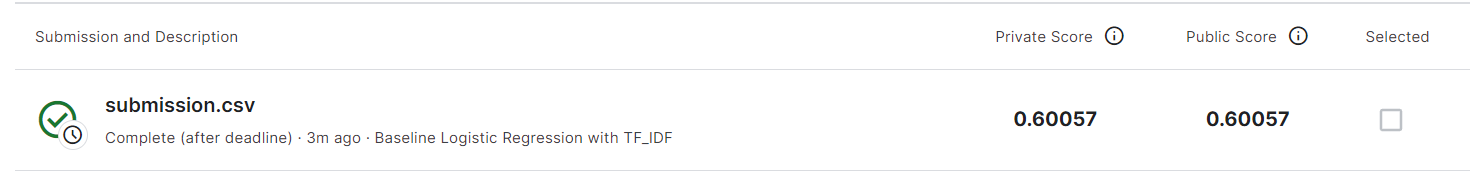



In [ ]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [ ]:
test_inputs

<66292x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 178146 stored elements in Compressed Sparse Row format>

In [ ]:
test_preds = lr.predict(test_inputs)

In [ ]:
test_preds

array([3, 3, 2, ..., 2, 2, 1])

In [ ]:
submission_df = submission_df.drop('Sentiment', axis=1)

In [ ]:
submission_df['Sentiment']  = test_preds

In [ ]:
submission_df.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


In [ ]:
submission_df.to_csv('submission.csv', index=None)

## Train & Finetune Different ML Models

Train & finetune at least 2 other types of models

Models Tried:
- Random Forests
- Naive Bayes

Optional:
* Use PCA for dimensionality reduction - Done
* Compare classification vs regression models


Tips:

- If using a regression model, make sure to round predictions to integer and clip to the range `[1,5]`
- Track your progress in a copy of [this experiment tracking spreadsheet](https://docs.google.com/spreadsheets/d/1X-tifxAOAYeIA2J32hBGP5B0MPnZy_o-zOz1NbS-1Ig/edit?usp=sharing)


### Model 2 - RandomForestClassifier

> Add blockquote
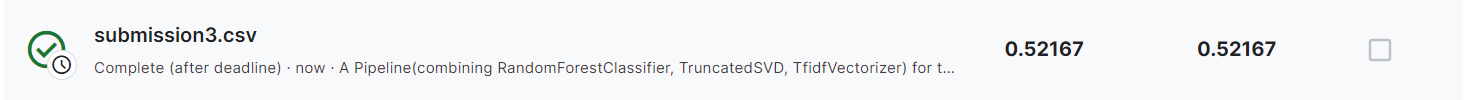


In [163]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [164]:
# Define the pipeline
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=tokenize,
                                 stop_words=filtered_stopwords,
                                 ngram_range=(1, 2),
                                 max_features=2000)),
        ("pca", TruncatedSVD(n_components=50)),  # Reduce to 50 components, adjust as needed
        ("clf", RandomForestClassifier(n_estimators=100))  # 100 trees in the forest, adjust as needed
    ]
)


In [165]:
TRAIN_EVAL_SPLIT_SIZE = 7000

In [183]:
sample_raw_df = raw_df.sample(10000, random_state=42)

In [166]:
# Split the data into training and testing sets
X_train = sample_raw_df.Phrase[:TRAIN_EVAL_SPLIT_SIZE]
y_train = sample_raw_df.Sentiment[:TRAIN_EVAL_SPLIT_SIZE]

In [167]:
X_train.shape, y_train.shape

((7000,), (7000,))

In [168]:
# Fit the model
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'movi', 'onc', 'ourselv', 'themselv', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenize at 0x7f7d0543add0>)),
                ('pca', TruncatedSVD(n_components=50)),
                ('clf', RandomForestClassifier())])

In [177]:
test_preds = pipeline.predict(test_df.Phrase)


In [178]:
test_preds

array([2, 2, 2, ..., 2, 2, 1])

In [180]:
submission_df = submission_df.drop('Sentiment', axis=1)


In [181]:
submission_df['Sentiment']  = test_preds

In [182]:
submission_df.to_csv('submission3.csv', index=None)

### Model 3 - Complement Naive Bayes

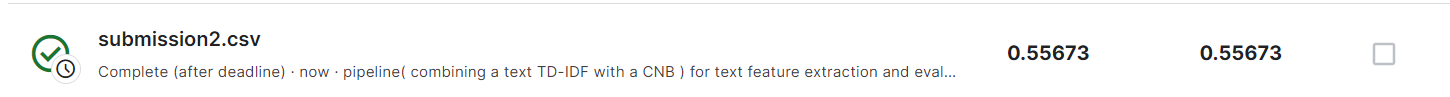

In [57]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

In [63]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", ComplementNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [64]:
import numpy as np

parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In [85]:
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [67]:
from time import time

t0 = time()
random_search.fit(raw_df.Phrase, raw_df.Sentiment)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Done in 505.294s


In [68]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 1.0
vect__max_df: 0.4
vect__min_df: 5
vect__ngram_range: (1, 2)
vect__norm: l1


In [71]:
best_model = random_search.best_estimator_

In [73]:
test_preds = best_model.predict(test_df.Phrase)

array([3, 3, 3, ..., 1, 1, 1])

In [77]:
test_accuracy = random_search.score(test_df.Phrase, test_preds)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.489
Accuracy on test set: 1.000


In [78]:
submission_df = submission_df.drop('Sentiment', axis=1)

In [79]:
submission_df['Sentiment']  = test_preds

In [81]:
submission_df.to_csv('submission2.csv', index=None)

Best Model:

Logistic Regression

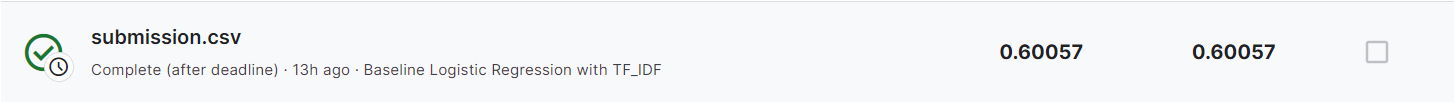(including Kaggle score screenshot)

## Submission and Future Work


How to make a submission:

- Add documentation and explanations
- Clean up any stray code/comments
- Include a screenshot of your best score
- Make a submission on the assignment page
- Review evaluation criteria carefully


Future work:
- Try more machine learning models
- Try configuring CountVectorizer differently
- Try approaches other than bag of words
